In [1]:
# TODO

#http://nlp.seas.harvard.edu/2018/04/03/attention.html

# Masking not based on zero as that's a real value that can occur 
# Propagate mask from beginning to respective section? 

# Prepend sth for the Sequences to start 

# consider positional embedding dim 

# To make addition of embeddings possible, dim of word embedding and dim of positional embedding should be equal (https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)



# Generates a prediction for the full seq len every time 

# Later: Positional embedding with different layer type/ computation? 


#### DONE at least partly

# Currently: Output sth like: None, 20, 20
# Most likely left over from class regression 
# Idea: Reduce that to actual None, 20 or sth to not have probabilty of embedding over each sampled token, but rather directly the sampled token
# (Further: Possibly only one token output? As in: The next token) 


In [2]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt

from Helpers import create_rolling_windows 

In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="Head2Eye", entity="sballe")

wandb: Currently logged in as: sballe (use `wandb login --relogin` to force relogin)


# Dataset

Surrogate data: Some sinusoidals that depend on each other. 
Create windows of length 'sequence_length', where input sequence is exactly that long and target sequence has prepended 0 as start symbol.

In [4]:
batch_size = 64
sequence_length = 200

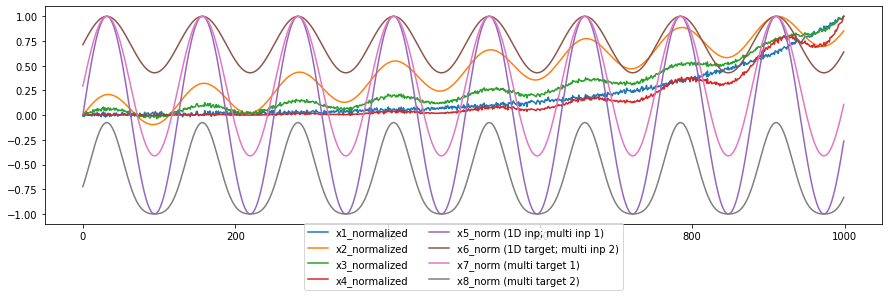

In [5]:
# Create surrogate sample data 

surrogate_samples = 1000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8
x6 = x5 * 0.2 + 0.4
x7 = x5 + x6 
x8 = x5 * x6 - 0.5

x1_factor = np.max(np.abs(x1))
x2_factor = np.max(np.abs(x2))
x3_factor = np.max(np.abs(x3))
x4_factor = np.max(np.abs(x4))
x5_factor = np.max(np.abs(x5))
x6_factor = np.max(np.abs(x6))
x7_factor = np.max(np.abs(x7))
x8_factor = np.max(np.abs(x8))


# normalize per time series
x1_normalized = x1 / x1_factor
x2_normalized = x2 / x2_factor
x3_normalized = x3 / x3_factor
x4_normalized = x4 / x4_factor
x5_normalized = x5 / x5_factor
x6_normalized = x6 / x6_factor
x7_normalized = x7 / x7_factor
x8_normalized = x8 / x8_factor


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.plot(range(len(x5_normalized)), x5_normalized, label='x5_norm (1D inp; multi inp 1)')
plt.plot(range(len(x6_normalized)), x6_normalized, label='x6_norm (1D target; multi inp 2)')
plt.plot(range(len(x7_normalized)), x7_normalized, label='x7_norm (multi target 1)')
plt.plot(range(len(x8_normalized)), x8_normalized, label='x8_norm (multi target 2)')
plt.legend(loc = "center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Shape surrogate pairs: (800, 2, 201)


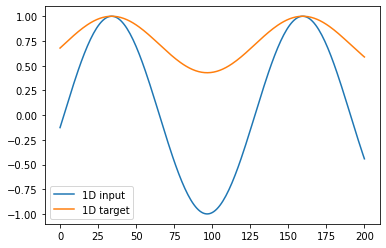

Shape surrogate quadrupels: (800, 4, 201)


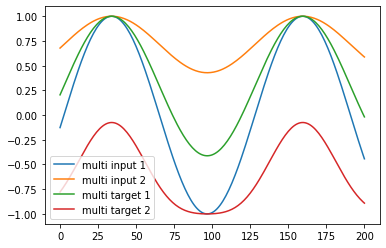

In [6]:
# Create windowed data 

# timeseries_dataset_from_array(data=x6_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)

# create window size as seq len + 1 for easy cutting later on 
window_size = sequence_length + 1

# window size 21
x5_windowed = create_rolling_windows(x5_normalized,window_size) # 1D input; multi input 1
x6_windowed = create_rolling_windows(x6_normalized,window_size) # 1D target; multi input 2
x7_windowed = create_rolling_windows(x7_normalized,window_size) # multi target 1
x8_windowed = create_rolling_windows(x8_normalized,window_size) # multi target 2 

surrogate_pairs = np.array([x5_windowed, x6_windowed])
surrogate_pairs = np.swapaxes(surrogate_pairs,0,1)
print("Shape surrogate pairs: " + str(surrogate_pairs.shape))
plt.plot(surrogate_pairs[123][0], label = "1D input") 
plt.plot(surrogate_pairs[123][1], label = "1D target")
plt.legend()
plt.show()

surrogate_quadruples = np.array([x5_windowed, x6_windowed, x7_windowed, x8_windowed])
surrogate_quadruples = np.swapaxes(surrogate_quadruples,0,1)
print("Shape surrogate quadrupels: " + str(surrogate_quadruples.shape))
plt.plot(surrogate_quadruples[123][0], label = "multi input 1") 
plt.plot(surrogate_quadruples[123][1], label = "multi input 2")
plt.plot(surrogate_quadruples[123][2], label = "multi target 1")
plt.plot(surrogate_quadruples[123][3], label = "multi target 2")
plt.legend()
plt.show()



In [8]:
val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_pairs)
num_val_samples = int(val_frac * len(surrogate_pairs))
num_train_samples = len(surrogate_pairs) - 2 * num_val_samples
train_pairs = surrogate_pairs[:num_train_samples]
val_pairs = surrogate_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = surrogate_pairs[num_train_samples + num_val_samples :]

print(f"{len(surrogate_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

800 total pairs
560 training pairs
120 validation pairs
120 test pairs


In [43]:
# Split pairs into inp and target 
train_inp_seqs = [pair[0] for pair in train_pairs]
train_target_seqs = [pair[1] for pair in train_pairs]
val_inp_seqs = [pair[0] for pair in val_pairs]
val_target_seqs = [pair[1] for pair in val_pairs]


# prepend 0 "start symbol" to all targets
'''
train_target_seqs = np.pad(train_target_seqs, pad_width = ((0,0),(1,0)), constant_values = 0)
val_target_seqs = np.pad(val_target_seqs, pad_width = ((0,0),(1,0)), constant_values = 0)
'''

print(np.shape(train_inp_seqs))
print(np.shape(train_target_seqs))
print(np.shape(val_inp_seqs))
print(np.shape(val_target_seqs))


(560, 201)
(560, 201)
(120, 201)
(120, 201)


In [44]:
        
def make_dataset(input_seqs,target_seqs):
    
    input_seqs = np.array(input_seqs).astype(float)
    target_seqs = np.array(target_seqs).astype(float)
    
    # Create dataset with inp sequence <-> target sequence pairs (both have length sequence_length)
    dataset = tf.data.Dataset.from_tensor_slices((input_seqs, target_seqs)) # tuple makes sure that inp matches correct target

    # batch 
    dataset = dataset.batch(batch_size)
    
    # format input/ outputs omitting last elem for decoder input and skipping first elem for target 
    # idea: instead of "word by word", show everything and do not omit first or last 
    dataset = dataset.map(format_dataset)
    
    return dataset.shuffle(2048).prefetch(16).cache()



def format_dataset(inp, target):
    
    
    # transformer architecture -> proceed word by word
    # full target sequence for input (i.e. 200)
    # 0 to N for decoder input (i.e. 200)
    # 1 to N+1 for target -> shifted by one (i.e. 200)
    
    return ({"encoder_inputs": inp[:, :-1], "decoder_inputs": target[:, :-1],}, target[:, 1:])
    #return ({"encoder_inputs": inp, "decoder_inputs": target[:, :-1],}, target)
    #return ({"encoder_inputs": inp, "decoder_inputs": target}, target)
    
    # orig
    # return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])
    

train_ds = make_dataset(train_inp_seqs,train_target_seqs)
val_ds = make_dataset(val_inp_seqs,val_target_seqs)

In [45]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (48, 200)
inputs["decoder_inputs"].shape: (48, 200)
targets.shape: (48, 200)


# Transformer Model

In [114]:



class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="tanh"), layers.Dense(embed_dim),] # activation relu 
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="float64") # dtype int32
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        
        print("Encoder Shape")
        print(self.layernorm_2(proj_input + proj_output))
        print()
        return self.layernorm_2(proj_input + proj_output)

    
    

class PositionalEmbedding(layers.Layer):
    
    
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        
        
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        
        embedded_positions = self.position_embeddings(positions)
        
        
        #print(inputs)
        #print(embedded_positions)
        
        #return embedded_tokens + embedded_positions # original
        return tf.expand_dims(inputs, axis=2) + embedded_positions # add actual numbers + positional embedding
        
        
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    
    # allow saving 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'embed_dim': self.embed_dim
        })
        return config
    
    

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="tanh"), layers.Dense(embed_dim),] # activation relu
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="float64") # dtype int32
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        
        print("Decoder Shape")
        print(self.layernorm_3(out_2 + proj_output))
        print()
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="float64") # dtype int32
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)





In [125]:

embed_dim = 256
latent_dim = 2048
num_heads = 8


encoder_inputs = keras.Input(shape=(None,), dtype="float64", name="encoder_inputs")
x_encoder = PositionalEmbedding(sequence_length, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x_encoder)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="float64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs") 
x_decoder = PositionalEmbedding(sequence_length, embed_dim)(decoder_inputs)
x_decoder = TransformerDecoder(embed_dim, latent_dim, num_heads)(x_decoder, encoded_seq_inputs)
x_decoder = layers.Dropout(0.5)(x_decoder)

# decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x) # orig
#decoder_outputs = layers.Dense(sequence_length, activation="softmax")(x_decoder)


#decoder_outputs = layers.Dense(sequence_length, activation="tanh")(x_decoder) 

decoder_outputs = layers.GlobalAveragePooling1D()(x_decoder)
#decoder_outputs1 = layers.Flatten(input_shape=(batch_size,embed_dim,sequence_length))(x_decoder)
decoder_outputs = layers.Dense(200, activation="tanh", input_shape=(batch_size,embed_dim*sequence_length))(decoder_outputs)



#decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])



transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)



Encoder Shape
Tensor("transformer_encoder_39/layer_normalization_169/add:0", shape=(None, None, 256), dtype=float32)

Decoder Shape
Tensor("transformer_decoder_30/layer_normalization_172/add:0", shape=(None, None, 256), dtype=float32)

Decoder Shape
Tensor("model_46/transformer_decoder_30/layer_normalization_172/add:0", shape=(None, None, 256), dtype=float32)



In [126]:
#error_sq = tf.math.squared_difference(y_pred, y_true)

def custom_mse(y_true, y_pred):
    
    print(y_true)
    print(y_pred)

    
    #squared_difference = tf.square(y_true - y_pred[:,0,:])
    
    #squared_difference = tf.square(y_true - y_pred[:,:,-1]) # last entry of each [prob not correct like this]
    
    
    #squared_difference = tf.square(y_true - y_pred[:,-1,:]) # last pred class, all values 
    squared_difference = tf.square(y_true - y_pred)

    
    return tf.reduce_mean(squared_difference) 


In [139]:
epochs = 30  # min 30 

transformer.summary()
transformer.compile(
    "adam", loss="mse", metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'] # rmsprop # sparse_categorical_crossentropy # mse
)

transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[WandbCallback()])

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding_82 (Positi (None, None, 256)    51200       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder_39 (Transfo (None, None, 256)    3155456     positional_embedding_82[0][0]    
________________________________________________________________________________________

In [146]:

max_decoded_sequence_length = 200

def decode_sequence(input_sequence, first_elem):
    
    decoded_sequence = np.zeros((max_decoded_sequence_length)) # text vectorization layer generates fixed len vector even for shorter input 
    decoded_sequence[0] = first_elem
    
    for i in range(max_decoded_sequence_length):
        
        #print("decode seq")
        #print(decoded_sequence)
        
        predictions = transformer.predict([np.array([input_sequence,]), np.array([decoded_sequence,])])  
        
        #print("predictions")
        #print(np.shape(predictions))
        #print(predictions)
        
        
        
        # todo: fix such that actual full seq is considered here, i.e. fix dataset by eg. shift for targets incl. start target -> making 200 -> 201
        if i < max_decoded_sequence_length - 1:
            sampled_token = predictions[0, i + 1]
            decoded_sequence[i+1] = sampled_token 
    
    return np.append(decoded_sequence, sampled_token) # add last token 



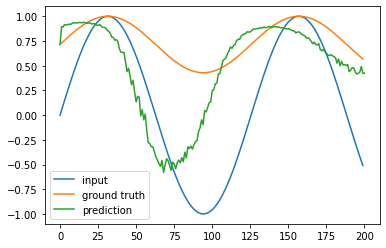

In [147]:
inp_seq = train_inp_seqs[0][:-1]
true_seq = train_target_seqs[0][:-1]
pred_seq = decode_sequence(inp_seq, true_seq[0])



plt.plot(inp_seq, label = "input")
plt.plot(true_seq, label = "ground truth")
plt.plot(pred_seq, label = "prediction")
plt.legend()
plt.show()

In [152]:
spa_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
)


decoded_sentence = ["[start] testword [end]"]
spa_vectorization.adapt(decoded_sentence)

print(spa_vectorization(np.array(decoded_sentence)))

print(spa_vectorization([decoded_sentence])[:, :-1])

tf.Tensor(
[[3 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 201), dtype=int64)
tf.Tensor(
[[3 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 200), dtype=int64)


In [ ]:
print(1/0)

In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

In [ ]:
print(1/0)

# Other Models

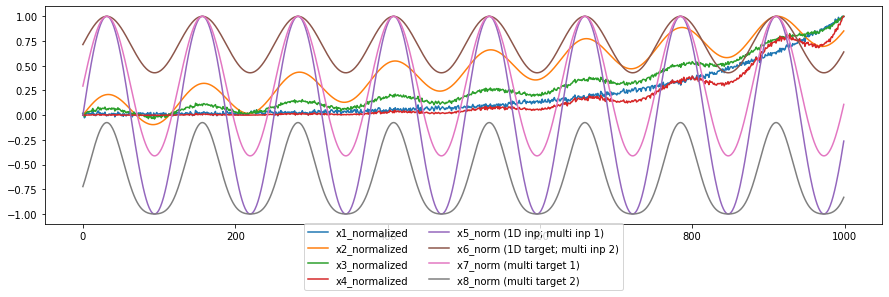

In [163]:
# Create surrogate sample data 

surrogate_samples = 1000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8
x6 = x5 * 0.2 + 0.4
x7 = x5 + x6 
x8 = x5 * x6 - 0.5

x1_factor = np.max(np.abs(x1))
x2_factor = np.max(np.abs(x2))
x3_factor = np.max(np.abs(x3))
x4_factor = np.max(np.abs(x4))
x5_factor = np.max(np.abs(x5))
x6_factor = np.max(np.abs(x6))
x7_factor = np.max(np.abs(x7))
x8_factor = np.max(np.abs(x8))


# normalize per time series
x1_normalized = x1 / x1_factor
x2_normalized = x2 / x2_factor
x3_normalized = x3 / x3_factor
x4_normalized = x4 / x4_factor
x5_normalized = x5 / x5_factor
x6_normalized = x6 / x6_factor
x7_normalized = x7 / x7_factor
x8_normalized = x8 / x8_factor


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.plot(range(len(x5_normalized)), x5_normalized, label='x5_norm (1D inp; multi inp 1)')
plt.plot(range(len(x6_normalized)), x6_normalized, label='x6_norm (1D target; multi inp 2)')
plt.plot(range(len(x7_normalized)), x7_normalized, label='x7_norm (multi target 1)')
plt.plot(range(len(x8_normalized)), x8_normalized, label='x8_norm (multi target 2)')
plt.legend(loc = "center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [164]:
batch_size = 64
sequence_length = 200

Shape surrogate pairs: (801, 2, 200)


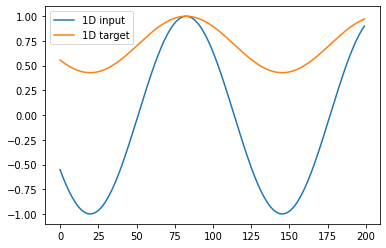

Shape surrogate quadrupels: (801, 4, 200)


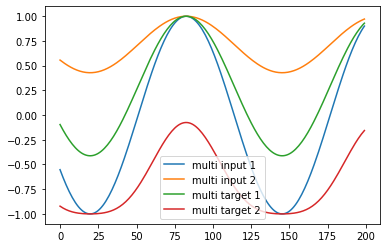

In [169]:
# Create windowed data 

# timeseries_dataset_from_array(data=x6_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)

# create window size as seq len
window_size = sequence_length

# window size 21
x5_windowed = create_rolling_windows(x5_normalized,window_size) # 1D input; multi input 1
x6_windowed = create_rolling_windows(x6_normalized,window_size) # 1D target; multi input 2
x7_windowed = create_rolling_windows(x7_normalized,window_size) # multi target 1
x8_windowed = create_rolling_windows(x8_normalized,window_size) # multi target 2 


surrogate_pairs = np.array([x5_windowed, x6_windowed])
surrogate_pairs = np.swapaxes(surrogate_pairs,0,1)
print("Shape surrogate pairs: " + str(surrogate_pairs.shape))
plt.plot(surrogate_pairs[200][0], label = "1D input") 
plt.plot(surrogate_pairs[200][1], label = "1D target")
plt.legend()
plt.show()

surrogate_quadruples = np.array([x5_windowed, x6_windowed, x7_windowed, x8_windowed])
surrogate_quadruples = np.swapaxes(surrogate_quadruples,0,1)
print("Shape surrogate quadrupels: " + str(surrogate_quadruples.shape))
plt.plot(surrogate_quadruples[200][0], label = "multi input 1") 
plt.plot(surrogate_quadruples[200][1], label = "multi input 2")
plt.plot(surrogate_quadruples[200][2], label = "multi target 1")
plt.plot(surrogate_quadruples[200][3], label = "multi target 2")
plt.legend()
plt.show()



In [170]:
val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_pairs)
num_val_samples = int(val_frac * len(surrogate_pairs))
num_train_samples = len(surrogate_pairs) - 2 * num_val_samples
train_pairs = surrogate_pairs[:num_train_samples]
val_pairs = surrogate_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = surrogate_pairs[num_train_samples + num_val_samples :]

print(f"{len(surrogate_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

801 total pairs
561 training pairs
120 validation pairs
120 test pairs


In [171]:
# Split pairs into inp and target 
train_inp_seqs = [pair[0] for pair in train_pairs]
train_target_seqs = [pair[1] for pair in train_pairs]
val_inp_seqs = [pair[0] for pair in val_pairs]
val_target_seqs = [pair[1] for pair in val_pairs]


print(np.shape(train_inp_seqs))
print(np.shape(train_target_seqs))
print(np.shape(val_inp_seqs))
print(np.shape(val_target_seqs))


(561, 200)
(561, 200)
(120, 200)
(120, 200)


# Basic model - 1D

In [172]:
X = np.array(train_inp_seqs)
Y = np.array(train_target_seqs)

tf.keras.backend.clear_session()

basic_model = keras.models.Sequential()
basic_model.add(layers.Dense(200, input_dim=sequence_length, activation='relu')) # relu
basic_model.add(layers.Dense(200, activation='relu')) # relu
basic_model.add(layers.Dense(200, activation='sigmoid')) # sigmoid
# compile the keras model
basic_model.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
basic_model.summary()
# fit the keras model on the dataset
basic_model.fit(X, Y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = basic_model.evaluate(X, Y)
print('Accuracy: %.2f' % (accuracy*100))



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
Total params: 120,600
Trainable params: 120,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
57/57 [==============================] - 1s 2ms/step - loss: 0.0391 - accuracy: 0.0362
Epoch 2/150
57/57 [==============================] - 0s 2ms/step - loss: 7.2727e-04 - accuracy: 0.0795
Epoch 3/150
57/57 [==============================] - 0s 2ms/step - loss: 3.1886e-04 - accuracy: 0.0894
Epoch 4/150
57/57 [==============================] - 0s 2ms/step - loss: 2.

18/18 [==============================] - 0s 1ms/step - loss: 1.0908e-05 - accuracy: 0.2478
Accuracy: 24.78


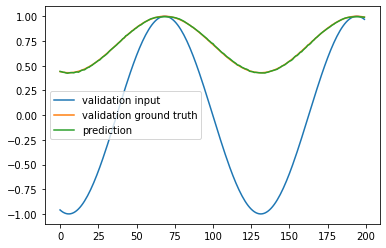

In [174]:
val_inp = np.array([val_inp_seqs[80]])
val_true = np.array([val_target_seqs[80]])
val_pred = basic_model.predict(val_inp)


plt.plot(val_inp[0], label = "validation input")
plt.plot(val_true[0], label = "validation ground truth")
plt.plot(val_pred[0], label = "prediction")
plt.legend()
plt.show()


# Basic Model - Multi dimensional

In [175]:
surrogate_quadruples

val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_quadruples)
num_val_samples = int(val_frac * len(surrogate_quadruples))
num_train_samples = len(surrogate_quadruples) - 2 * num_val_samples
train_quads = surrogate_quadruples[:num_train_samples]
val_quads = surrogate_quadruples[num_train_samples : num_train_samples + num_val_samples]
test_quads = surrogate_quadruples[num_train_samples + num_val_samples :]

print(f"{len(surrogate_quadruples)} total quads")
print(f"{len(train_quads)} training quads")
print(f"{len(val_quads)} validation quads")
print(f"{len(test_quads)} test quads")






801 total quads
561 training quads
120 validation quads
120 test quads


In [176]:
X = np.array(train_quads[:,0:2,:])
X = X.reshape(X.shape[0],-1)
Y = np.array(train_quads[:,2:,:])
Y = Y.reshape(Y.shape[0],-1)

tf.keras.backend.clear_session()

basic_model_multi = keras.models.Sequential()
basic_model_multi.add(layers.Dense(400, input_dim = X.shape[1], activation='tanh')) # relu
basic_model_multi.add(layers.Dense(400, activation='tanh')) # relu
basic_model_multi.add(layers.Dense(400, activation='tanh')) # sigmoid
# compile the keras model
basic_model_multi.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
basic_model_multi.summary()
# fit the keras model on the dataset
basic_model_multi.fit(X, Y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = basic_model_multi.evaluate(X, Y)
print('Accuracy: %.2f' % (accuracy*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
Total params: 481,200
Trainable params: 481,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
57/57 [==============================] - 1s 3ms/step - loss: 0.0980 - accuracy: 0.0362
Epoch 2/150
57/57 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.0656
Epoch 3/150
57/57 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.0672
Epoch 4/150
57/57 [==============================] - 0s 3ms/step - loss: 8.4994e-04

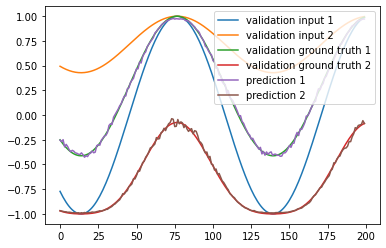

In [177]:
# use from train dataset 
if False:
    val_inp = np.array([X[200,:]])
    val_true = np.array([Y[200,:]])
# use actual validation 
else:
    val_inp = np.array(val_quads[:,0:2,:])
    val_inp = val_inp.reshape(val_inp.shape[0],-1)
    val_inp = np.array([val_inp[100,:]])
    val_true = np.array(val_quads[:,2:4,:])
    val_true = val_true.reshape(val_true.shape[0],-1)
    val_true = np.array([val_true[100,:]])
    
val_out = basic_model_multi(val_inp) # predict 
    

plt.plot(val_inp[0][0:200], label = "validation input 1")
plt.plot(val_inp[0][200:400], label = "validation input 2")
plt.plot(val_true[0][0:200], label = "validation ground truth 1")
plt.plot(val_true[0][200:400], label = "validation ground truth 2")
plt.plot(val_out[0][0:200], label = "prediction 1")
plt.plot(val_out[0][200:400], label = "prediction 2")
plt.legend()
plt.show()